In [ ]:
import numpy as np
import pandas as pd
import os

data_dir_0 = '/kaggle/input/inme-veri-seti-stroke-dataset'
for root, dirs, files in os.walk(data_dir_0):
    print(root, len(files), 'files')

/kaggle/input/inme-veri-seti-stroke-dataset 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ 2 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/İnme Yok 4551 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/DICOM 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/OVERLAY 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/Kanama/PNG 1093 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum 0 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/DICOM 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/OVERLAY 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/MASKS 100 files
/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/P

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import kagglehub

print("--- Setup and Downloads ---")

try:
    dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")
    print(f"Dataset downloaded to: {dataset_path}")
    data_dir = os.path.join(dataset_path, 'İNME VERİ SETİ')
    print(f"Using data directory: {data_dir}")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Attempting to use default Kaggle input path...")
    data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'
    if not os.path.exists(data_dir):
         print(f"ERROR: Default data directory not found either: {data_dir}")
         print("Please ensure the dataset is correctly attached to your environment.")
         data_dir = None
    else:
         print(f"Using default input directory: {data_dir}")

print("Skipping download of 'huongtraa/resnet18-f37072fd_classification' weights.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU found: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU found, using CPU.")

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
RANDOM_STATE = 42

print("\n--- Data Preparation ---")

if data_dir and os.path.exists(data_dir):
    ischemic_path = os.path.join(data_dir, "İskemi/PNG")
    hemorrhagic_path = os.path.join(data_dir, "Kanama/PNG")

    if not os.path.exists(ischemic_path):
        print(f"ERROR: Ischemic path not found: {ischemic_path}")
    if not os.path.exists(hemorrhagic_path):
        print(f"ERROR: Hemorrhagic path not found: {hemorrhagic_path}")

    image_paths = []
    labels = []

    ischemic_files = glob.glob(os.path.join(ischemic_path, '*.png'))
    image_paths.extend(ischemic_files)
    labels.extend([0] * len(ischemic_files))
    print(f"Found {len(ischemic_files)} ischemic images.")

    hemorrhagic_files = glob.glob(os.path.join(hemorrhagic_path, '*.png'))
    image_paths.extend(hemorrhagic_files)
    labels.extend([1] * len(hemorrhagic_files))
    print(f"Found {len(hemorrhagic_files)} hemorrhagic images.")

    if not image_paths:
        print("ERROR: No images found. Check dataset paths and content.")
    else:
        print(f"Total images found: {len(image_paths)}")
        print(f"Total labels found: {len(labels)}")

        train_files, val_files, train_labels, val_labels = train_test_split(
            image_paths, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
        )
        print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

        class PNGDataset(Dataset):
            def __init__(self, image_paths, labels, transform=None):
                self.image_paths = image_paths
                self.labels = labels
                self.transform = transform

            def __len__(self):
                return len(self.image_paths)

            def __getitem__(self, idx):
                image_path = self.image_paths[idx]
                label = self.labels[idx]

                try:
                    img = Image.open(image_path).convert("RGB")
                except Exception as e:
                    print(f"Warning: Error loading image {image_path}: {e}. Returning blank image.")
                    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (128, 128, 128))

                if self.transform:
                    img = self.transform(img)

                return img, torch.tensor(label, dtype=torch.long)

        transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        train_dataset = PNGDataset(image_paths=train_files, labels=train_labels, transform=transform)
        val_dataset = PNGDataset(image_paths=val_files, labels=val_labels, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

        print("DataLoaders created.")

        print("\n--- Model Setup ---")

        print("Loading ResNet-18 with standard ImageNet pre-trained weights.")
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
        print("Modified final layer for 2 classes.")

        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print("Model, Loss function, and Optimizer defined.")

        print("\n--- Training ---")

        best_val_accuracy = 0.0
        os.makedirs("/kaggle/working/models", exist_ok=True)
        best_model_path = '/kaggle/working/models/best_classifier_imagenet.pth'

        for epoch in range(NUM_EPOCHS):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            epoch_loss_train = running_loss / len(train_loader.dataset)
            epoch_accuracy_train = 100 * correct_train / total_train

            model.eval()
            running_loss_val = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss_val += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            epoch_loss_val = running_loss_val / len(val_loader.dataset)
            epoch_accuracy_val = 100 * correct_val / total_val

            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
                  f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_accuracy_train:.2f}% | "
                  f"Val Loss: {epoch_loss_val:.4f}, Val Acc: {epoch_accuracy_val:.2f}%")

            if epoch_accuracy_val > best_val_accuracy:
                best_val_accuracy = epoch_accuracy_val
                torch.save(model.state_dict(), best_model_path)
                print(f"*** Best model saved to {best_model_path} (Val Acc: {best_val_accuracy:.2f}%) ***")

        print("\nTraining complete!")
        print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}%")

        print("\n--- Final Evaluation on Validation Set (using best model) ---")

        if os.path.exists(best_model_path):
             model.load_state_dict(torch.load(best_model_path))
             model.eval()

             y_true = []
             y_pred = []
             with torch.no_grad():
                 for inputs, labels in val_loader:
                     inputs, labels = inputs.to(device), labels.to(device)
                     outputs = model(inputs)
                     _, preds = torch.max(outputs, 1)
                     y_true.extend(labels.cpu().numpy())
                     y_pred.extend(preds.cpu().numpy())

             accuracy = accuracy_score(y_true, y_pred)
             precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
             recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
             f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)

             print("Validation Metrics (Best Model):")
             print(f"Accuracy : {accuracy:.4f}")
             print(f"Precision: {precision:.4f}")
             print(f"Recall   : {recall:.4f}")
             print(f"F1 Score : {f1:.4f}")
        else:
             print(f"Warning: Best model file not found at {best_model_path}. Skipping final evaluation.")

        print("\n--- Prediction Demo ---")

        def demo_classifier_model(image_path, model, device, transform):
            if not os.path.exists(image_path):
                print(f"Error: Demo image path not found: {image_path}")
                return

            try:
                img = Image.open(image_path).convert("RGB")
                input_tensor = transform(img).unsqueeze(0).to(device)

                model.eval()
                with torch.no_grad():
                    output = model(input_tensor)
                    probabilities = torch.softmax(output, dim=1)
                    _, pred_idx = torch.max(probabilities, 1)
                    pred_label = pred_idx.item()
                    pred_confidence = probabilities[0, pred_label].item()

                class_names = ['İskemi (0)', 'Kanama (1)']
                print(f"\n📷 Image: {os.path.basename(image_path)}")
                print(f"🧠 Predicted Label: {class_names[pred_label]}")
                print(f"💡 Confidence: {pred_confidence:.4f}")

            except Exception as e:
                print(f"Error processing demo image {image_path}: {e}")

        if val_files:
             demo_image_path = val_files[0]
             demo_classifier_model(demo_image_path, model, device, transform)
        else:
             print("No validation files found to run demo.")

else:
    print("\n--- Data directory not available. Skipping Data Preparation, Training, and Evaluation. ---")


print("\n--- Script Finished ---")

--- Setup and Downloads ---
Dataset downloaded to: /kaggle/input/inme-veri-seti-stroke-dataset
Using data directory: /kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ
Skipping download of 'huongtraa/resnet18-f37072fd_classification' weights.
GPU found: Tesla P100-PCIE-16GB

--- Data Preparation ---
Found 1130 ischemic images.
Found 1093 hemorrhagic images.
Total images found: 2223
Total labels found: 2223
Training samples: 1778, Validation samples: 445
DataLoaders created.

--- Model Setup ---
Loading ResNet-18 with standard ImageNet pre-trained weights.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s] 


Modified final layer for 2 classes.
Model, Loss function, and Optimizer defined.

--- Training ---
Epoch [1/10] | Train Loss: 0.4465, Train Acc: 80.93% | Val Loss: 0.2404, Val Acc: 91.46%
*** Best model saved to /kaggle/working/models/best_classifier_imagenet.pth (Val Acc: 91.46%) ***
Epoch [2/10] | Train Loss: 0.1984, Train Acc: 91.56% | Val Loss: 0.2006, Val Acc: 93.48%
*** Best model saved to /kaggle/working/models/best_classifier_imagenet.pth (Val Acc: 93.48%) ***
Epoch [3/10] | Train Loss: 0.1113, Train Acc: 95.95% | Val Loss: 0.1672, Val Acc: 94.38%
*** Best model saved to /kaggle/working/models/best_classifier_imagenet.pth (Val Acc: 94.38%) ***
Epoch [4/10] | Train Loss: 0.0894, Train Acc: 96.96% | Val Loss: 0.2628, Val Acc: 93.48%
Epoch [5/10] | Train Loss: 0.0758, Train Acc: 96.96% | Val Loss: 4.4781, Val Acc: 49.89%
Epoch [6/10] | Train Loss: 0.0834, Train Acc: 97.08% | Val Loss: 0.2697, Val Acc: 91.24%
Epoch [7/10] | Train Loss: 0.0437, Train Acc: 98.37% | Val Loss: 0.5594, 

<ipython-input-2-08e1caabc66f>:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Validation Metrics (Best Model):
Accuracy : 0.9573
Precision: 0.9717
Recall   : 0.9406
F1 Score : 0.9559

--- Prediction Demo ---

📷 Image: 10332.png
🧠 Predicted Label: İskemi (0)
💡 Confidence: 0.6831

--- Script Finished ---


--- Setup and Downloads ---
Dataset downloaded via kagglehub to: /kaggle/input/inme-veri-seti-stroke-dataset
Using base data directory: /kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ
Model and plots will be saved in: /kaggle/working/models
Using device: cuda
GPU: Tesla P100-PCIE-16GB

--- Data Preparation (Train/Validation) ---
Found 1130 ischemic images.
Found 1093 hemorrhagic images.
Total train/val images found: 2223
Training samples: 1778, Validation samples: 445

--- Data Preparation (Test Set) ---
Found 97 images in the test set directory (/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/PNG).
DataLoaders created.

--- Model Setup ---
Loading ResNet-18 with standard ImageNet pre-trained weights.
Modified final layer for 2 classes.
Model, Loss function, and Optimizer defined.

--- Training ---
Epoch [1/30] | Train Loss: 0.3834, Train Acc: 84.81% | Val Loss: 0.2435, Val Acc: 91.46%
*** Best model saved to /kaggle/working/models/best_cl

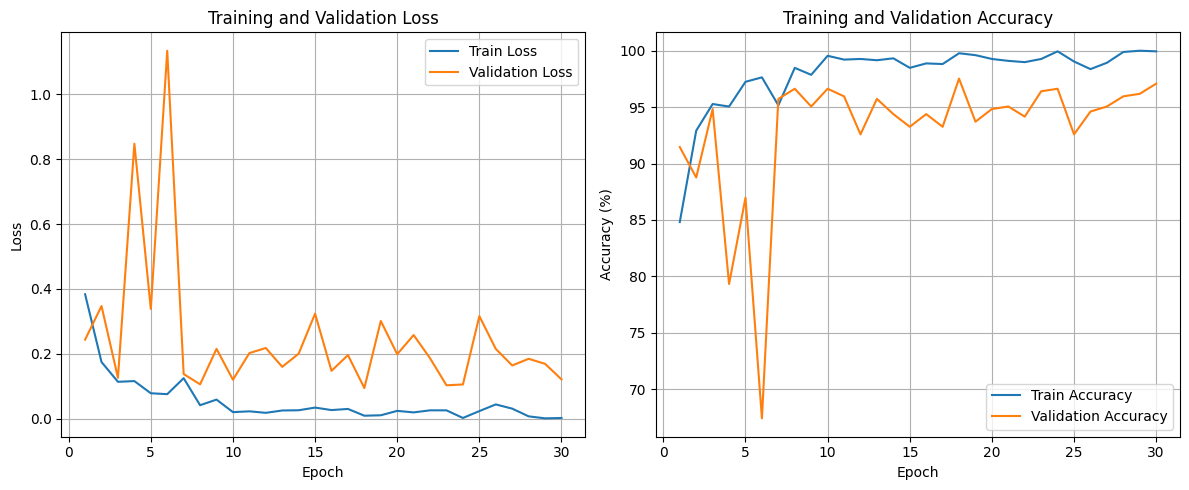


--- Final Evaluation on VALIDATION Set (using best model) ---
Loading best model from: /kaggle/working/models/best_classifier_imagenet.pth


<ipython-input-5-7ed27b04f12d>:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))



Validation Metrics (Best Model):
Accuracy : 0.9753
Precision (for Kanama): 0.9727
Recall (for Kanama)   : 0.9772
F1 Score (for Kanama) : 0.9749
Validation confusion matrix saved to: /kaggle/working/models/validation_confusion_matrix.png


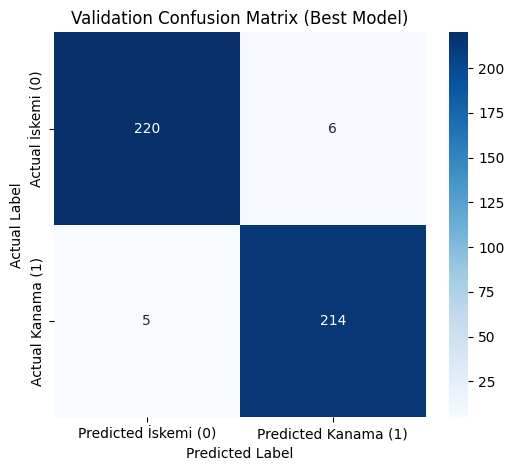


--- Generating Predictions on TEST Set ---
NOTE: Ground truth labels for the test set are unknown.
      Metrics cannot be calculated. Generating predictions only.
Running inference on test images...
Generated 97 predictions for the test set.

Example Test Predictions (Image Path -> Predicted Label [0=İskemi, 1=Kanama]):
14750.png -> 0
12508.png -> 0
14715.png -> 0
14095.png -> 1
13368.png -> 0
16589.png -> 1
10583.png -> 0
10147.png -> 1
15659.png -> 0
15899.png -> 1

--- Script Finished ---


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns

print("--- Setup and Downloads ---")

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
RANDOM_STATE = 42
MODEL_SAVE_DIR = "/kaggle/working/models"
BEST_MODEL_NAME = 'best_classifier_imagenet.pth'
PLOT_SAVE_NAME = 'training_metrics.png'
CONFUSION_MATRIX_SAVE_NAME = 'validation_confusion_matrix.png'

try:
    dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")
    print(f"Dataset downloaded via kagglehub to: {dataset_path}")
    base_data_dir = os.path.join(dataset_path, 'İNME VERİ SETİ')
except Exception as e:
    print(f"Warning: kagglehub dataset download failed: {e}")
    print("Attempting to use default Kaggle input path...")
    base_data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'

print(f"Using base data directory: {base_data_dir}")

if not os.path.isdir(base_data_dir):
     print(f"ERROR: Base data directory not found: {base_data_dir}")
     print("Please ensure the dataset is correctly attached or downloaded.")
     exit()

ischemic_path = os.path.join(base_data_dir, "İskemi/PNG")
hemorrhagic_path = os.path.join(base_data_dir, "Kanama/PNG")
test_png_path = os.path.join(base_data_dir, "YarısmaVeriSeti_2_Oturum/PNG")

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Model and plots will be saved in: {MODEL_SAVE_DIR}")

best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
plot_save_path = os.path.join(MODEL_SAVE_DIR, PLOT_SAVE_NAME)
cm_save_path = os.path.join(MODEL_SAVE_DIR, CONFUSION_MATRIX_SAVE_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n--- Data Preparation (Train/Validation) ---")

image_paths = []
labels = []

ischemic_files = glob.glob(os.path.join(ischemic_path, '*.png'))
if not ischemic_files: print(f"Warning: No files found in {ischemic_path}")
image_paths.extend(ischemic_files)
labels.extend([0] * len(ischemic_files))
print(f"Found {len(ischemic_files)} ischemic images.")

hemorrhagic_files = glob.glob(os.path.join(hemorrhagic_path, '*.png'))
if not hemorrhagic_files: print(f"Warning: No files found in {hemorrhagic_path}")
image_paths.extend(hemorrhagic_files)
labels.extend([1] * len(hemorrhagic_files))
print(f"Found {len(hemorrhagic_files)} hemorrhagic images.")

if not image_paths:
    print("ERROR: No training/validation images found. Exiting.")
    exit()
else:
    print(f"Total train/val images found: {len(image_paths)}")

train_files, val_files, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

print("\n--- Data Preparation (Test Set) ---")
test_files = glob.glob(os.path.join(test_png_path, '*.png'))
if not test_files:
    print(f"Warning: No files found in the test directory: {test_png_path}")
else:
    print(f"Found {len(test_files)} images in the test set directory ({test_png_path}).")

test_labels_dummy = [0] * len(test_files)

class PNGDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, is_test=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {image_path}: {e}. Returning blank image.")
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (128, 128, 128))

        if self.transform:
            img = self.transform(img)

        if self.is_test:
             return img, torch.tensor(label, dtype=torch.long), image_path
        else:
             return img, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = PNGDataset(image_paths=train_files, labels=train_labels, transform=transform)
val_dataset = PNGDataset(image_paths=val_files, labels=val_labels, transform=val_test_transform)
if test_files:
    test_dataset = PNGDataset(image_paths=test_files, labels=test_labels_dummy, transform=val_test_transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
if test_files:
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created.")

print("\n--- Model Setup ---")
print("Loading ResNet-18 with standard ImageNet pre-trained weights.")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
print("Modified final layer for 2 classes.")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model, Loss function, and Optimizer defined.")

print("\n--- Training ---")

best_val_accuracy = 0.0
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss_train = running_loss_train / total_train if total_train > 0 else 0
    epoch_accuracy_train = 100 * correct_train / total_train if total_train > 0 else 0

    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss_val = running_loss_val / total_val if total_val > 0 else 0
    epoch_accuracy_val = 100 * correct_val / total_val if total_val > 0 else 0

    history['train_loss'].append(epoch_loss_train)
    history['val_loss'].append(epoch_loss_val)
    history['train_acc'].append(epoch_accuracy_train)
    history['val_acc'].append(epoch_accuracy_val)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_accuracy_train:.2f}% | "
          f"Val Loss: {epoch_loss_val:.4f}, Val Acc: {epoch_accuracy_val:.2f}%")

    if epoch_accuracy_val > best_val_accuracy:
        best_val_accuracy = epoch_accuracy_val
        torch.save(model.state_dict(), best_model_path)
        print(f"*** Best model saved to {best_model_path} (Val Acc: {best_val_accuracy:.2f}%) ***")

print("\nTraining complete!")
print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}%")
print(f"Best model weights saved to: {best_model_path}")

print("\n--- Plotting Training Metrics ---")
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
try:
    plt.savefig(plot_save_path)
    print(f"Training metrics plot saved to: {plot_save_path}")
except Exception as e:
    print(f"Error saving plot: {e}")
plt.show()

print("\n--- Final Evaluation on VALIDATION Set (using best model) ---")

if os.path.exists(best_model_path):
     print(f"Loading best model from: {best_model_path}")
     model.load_state_dict(torch.load(best_model_path))
     model.eval()

     y_true_val = []
     y_pred_val = []
     with torch.no_grad():
         for inputs, labels in val_loader:
             inputs, labels = inputs.to(device), labels.to(device)
             outputs = model(inputs)
             _, preds = torch.max(outputs, 1)
             y_true_val.extend(labels.cpu().numpy())
             y_pred_val.extend(preds.cpu().numpy())

     accuracy = accuracy_score(y_true_val, y_pred_val)
     precision = precision_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
     recall = recall_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
     f1 = f1_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)

     print("\nValidation Metrics (Best Model):")
     print(f"Accuracy : {accuracy:.4f}")
     print(f"Precision (for Kanama): {precision:.4f}")
     print(f"Recall (for Kanama)   : {recall:.4f}")
     print(f"F1 Score (for Kanama) : {f1:.4f}")

     cm = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1])
     plt.figure(figsize=(6, 5))
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=['Predicted İskemi (0)', 'Predicted Kanama (1)'],
                 yticklabels=['Actual İskemi (0)', 'Actual Kanama (1)'])
     plt.ylabel('Actual Label')
     plt.xlabel('Predicted Label')
     plt.title('Validation Confusion Matrix (Best Model)')
     try:
         plt.savefig(cm_save_path)
         print(f"Validation confusion matrix saved to: {cm_save_path}")
     except Exception as e:
         print(f"Error saving confusion matrix plot: {e}")
     plt.show()

else:
     print(f"ERROR: Best model file not found at {best_model_path}. Cannot perform final validation evaluation.")

print("\n--- Generating Predictions on TEST Set ---")
print("NOTE: Ground truth labels for the test set are unknown.")
print("      Metrics cannot be calculated. Generating predictions only.")

if test_files and os.path.exists(best_model_path):
    if 'test_loader' not in locals():
         print("Error: test_loader not defined (likely no test files found).")
    else:
        model.eval()
        test_predictions = []
        test_image_paths = []
        print("Running inference on test images...")
        with torch.no_grad():
            for inputs, _, paths in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_predictions.extend(preds.cpu().numpy())
                test_image_paths.extend(paths)

        print(f"Generated {len(test_predictions)} predictions for the test set.")

        print("\nExample Test Predictions (Image Path -> Predicted Label [0=İskemi, 1=Kanama]):")
        for i in range(min(10, len(test_predictions))):
             print(f"{os.path.basename(test_image_paths[i])} -> {test_predictions[i]}")

elif not test_files:
    print("Skipping test set prediction as no test files were found.")
else:
    print("Skipping test set prediction as best model file was not found.")

print("\n--- Script Finished ---")

--- Setup and Downloads ---
Dataset downloaded via kagglehub to: /kaggle/input/inme-veri-seti-stroke-dataset
Using base data directory: /kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ
Model and plots will be saved in: /kaggle/working/models
Using device: cuda
GPU: Tesla P100-PCIE-16GB

--- Data Preparation (Train/Validation) ---
Found 1130 ischemic images.
Found 1093 hemorrhagic images.
Total train/val images found: 2223
Training samples: 1778, Validation samples: 445

--- Data Preparation (Test Set) ---
Found 97 images in the test set directory (/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/PNG).
DataLoaders created.

--- Model Setup ---
Using Custom SimpleCNN model.
Model, Loss function, and Optimizer defined.

--- Training ---
Epoch [1/30] | Train Loss: 0.8504, Train Acc: 60.85% | Val Loss: 0.5343, Val Acc: 71.24%
*** Best model saved to /kaggle/working/models/best_classifier_cnn.pth (Val Acc: 71.24%) ***
Epoch [2/30] | Train Loss: 0.

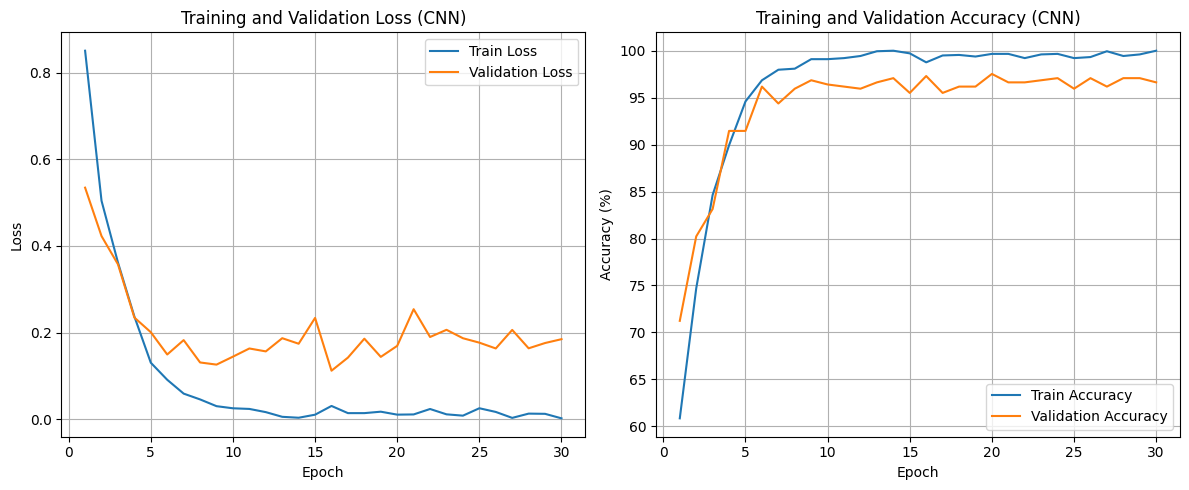


--- Final Evaluation on VALIDATION Set (using best model) ---
Loading best model weights from: /kaggle/working/models/best_classifier_cnn.pth


<ipython-input-7-6946e57285ea>:379: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))



Validation Metrics (Best CNN Model):
Accuracy : 0.9753
Precision (for Kanama): 0.9860
Recall (for Kanama)   : 0.9635
F1 Score (for Kanama) : 0.9746
Validation confusion matrix saved to: /kaggle/working/models/validation_confusion_matrix_cnn.png


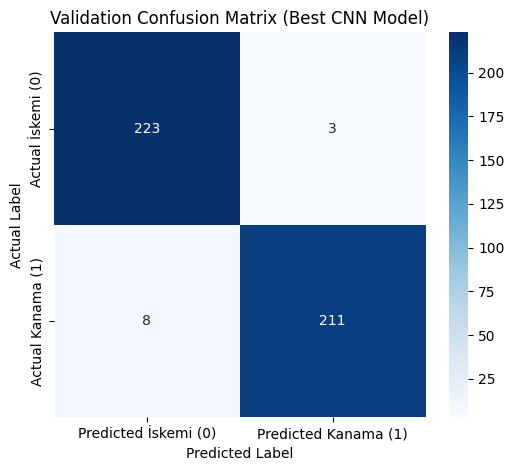


--- Generating Predictions on TEST Set ---
NOTE: Ground truth labels for the test set are unknown.
      Metrics cannot be calculated. Generating predictions only.
Running inference on test images...
Generated 97 predictions for the test set.

Example Test Predictions (Image Path -> Predicted Label [0=İskemi, 1=Kanama]):
14750.png -> 0
12508.png -> 1
14715.png -> 0
14095.png -> 0
13368.png -> 0
16589.png -> 1
10583.png -> 0
10147.png -> 1
15659.png -> 0
15899.png -> 0

Test predictions saved to: /kaggle/working/models/test_predictions_cnn.csv

--- Script Finished ---


In [ ]:


print("--- Setup and Downloads ---")

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
RANDOM_STATE = 42
MODEL_SAVE_DIR = "/kaggle/working/models"
BEST_MODEL_NAME = 'best_classifier_cnn.pth'
PLOT_SAVE_NAME = 'training_metrics_cnn.png'
CONFUSION_MATRIX_SAVE_NAME = 'validation_confusion_matrix_cnn.png'

try:
    dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")
    print(f"Dataset downloaded via kagglehub to: {dataset_path}")
    base_data_dir = os.path.join(dataset_path, 'İNME VERİ SETİ')
except Exception as e:
    print(f"Warning: kagglehub dataset download failed: {e}")
    print("Attempting to use default Kaggle input path...")
    base_data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'

print(f"Using base data directory: {base_data_dir}")

if not os.path.isdir(base_data_dir):
     print(f"ERROR: Base data directory not found: {base_data_dir}")
     print("Please ensure the dataset is correctly attached or downloaded.")
     exit()

ischemic_path = os.path.join(base_data_dir, "İskemi/PNG")
hemorrhagic_path = os.path.join(base_data_dir, "Kanama/PNG")
test_png_path = os.path.join(base_data_dir, "YarısmaVeriSeti_2_Oturum/PNG")

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Model and plots will be saved in: {MODEL_SAVE_DIR}")

best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
plot_save_path = os.path.join(MODEL_SAVE_DIR, PLOT_SAVE_NAME)
cm_save_path = os.path.join(MODEL_SAVE_DIR, CONFUSION_MATRIX_SAVE_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\n--- Data Preparation (Train/Validation) ---")

image_paths = []
labels = []

ischemic_files = glob.glob(os.path.join(ischemic_path, '*.png'))
if not ischemic_files: print(f"Warning: No files found in {ischemic_path}")
image_paths.extend(ischemic_files)
labels.extend([0] * len(ischemic_files))
print(f"Found {len(ischemic_files)} ischemic images.")

hemorrhagic_files = glob.glob(os.path.join(hemorrhagic_path, '*.png'))
if not hemorrhagic_files: print(f"Warning: No files found in {hemorrhagic_path}")
image_paths.extend(hemorrhagic_files)
labels.extend([1] * len(hemorrhagic_files))
print(f"Found {len(hemorrhagic_files)} hemorrhagic images.")

if not image_paths:
    print("ERROR: No training/validation images found. Exiting.")
    exit()
else:
    print(f"Total train/val images found: {len(image_paths)}")

train_files, val_files, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

print("\n--- Data Preparation (Test Set) ---")
test_files = glob.glob(os.path.join(test_png_path, '*.png'))
if not test_files:
    print(f"Warning: No files found in the test directory: {test_png_path}")
else:
    print(f"Found {len(test_files)} images in the test set directory ({test_png_path}).")

test_labels_dummy = [0] * len(test_files)

class PNGDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, is_test=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            img = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {image_path}: {e}. Returning blank image.")
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (128, 128, 128))

        if self.transform:
            img = self.transform(img)

        if self.is_test:
             return img, torch.tensor(label, dtype=torch.long), image_path
        else:
             return img, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = PNGDataset(image_paths=train_files, labels=train_labels, transform=transform)
val_dataset = PNGDataset(image_paths=val_files, labels=val_labels, transform=val_test_transform)
if test_files:
    test_dataset = PNGDataset(image_paths=test_files, labels=test_labels_dummy, transform=val_test_transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
if test_files:
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created.")

print("\n--- Model Setup ---")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = 64 * 28 * 28

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.flattened_size)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

print("Using Custom SimpleCNN model.")
model = SimpleCNN(num_classes=2)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model, Loss function, and Optimizer defined.")

print("\n--- Training ---")

best_val_accuracy = 0.0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss_train = running_loss_train / total_train if total_train > 0 else 0
    epoch_accuracy_train = 100 * correct_train / total_train if total_train > 0 else 0

    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss_val = running_loss_val / total_val if total_val > 0 else 0
    epoch_accuracy_val = 100 * correct_val / total_val if total_val > 0 else 0

    history['train_loss'].append(epoch_loss_train)
    history['val_loss'].append(epoch_loss_val)
    history['train_acc'].append(epoch_accuracy_train)
    history['val_acc'].append(epoch_accuracy_val)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_accuracy_train:.2f}% | "
          f"Val Loss: {epoch_loss_val:.4f}, Val Acc: {epoch_accuracy_val:.2f}%")

    if epoch_accuracy_val > best_val_accuracy:
        best_val_accuracy = epoch_accuracy_val
        torch.save(model.state_dict(), best_model_path)
        print(f"*** Best model saved to {best_model_path} (Val Acc: {best_val_accuracy:.2f}%) ***")

print("\nTraining complete!")
print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}%")
print(f"Best model weights saved to: {best_model_path}")

print("\n--- Plotting Training Metrics ---")
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (CNN)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (CNN)')
plt.legend()
plt.grid(True)

plt.tight_layout()
try:
    plt.savefig(plot_save_path)
    print(f"Training metrics plot saved to: {plot_save_path}")
except Exception as e:
    print(f"Error saving plot: {e}")
plt.show()

print("\n--- Final Evaluation on VALIDATION Set (using best model) ---")

model = SimpleCNN(num_classes=2)
model.to(device)

if os.path.exists(best_model_path):
     print(f"Loading best model weights from: {best_model_path}")
     try:
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        model.eval()

        y_true_val = []
        y_pred_val = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        accuracy = accuracy_score(y_true_val, y_pred_val)
        precision = precision_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
        recall = recall_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
        f1 = f1_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)

        print("\nValidation Metrics (Best CNN Model):")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision (for Kanama): {precision:.4f}")
        print(f"Recall (for Kanama)   : {recall:.4f}")
        print(f"F1 Score (for Kanama) : {f1:.4f}")

        cm = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1])
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted İskemi (0)', 'Predicted Kanama (1)'],
                    yticklabels=['Actual İskemi (0)', 'Actual Kanama (1)'])
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.title('Validation Confusion Matrix (Best CNN Model)')
        try:
            plt.savefig(cm_save_path)
            print(f"Validation confusion matrix saved to: {cm_save_path}")
        except Exception as e:
            print(f"Error saving confusion matrix plot: {e}")
        plt.show()

     except Exception as e:
        print(f"Error loading model state_dict: {e}")
        print("Ensure the model architecture definition matches the saved weights.")

else:
     print(f"ERROR: Best model file not found at {best_model_path}. Cannot perform final validation evaluation.")


print("\n--- Generating Predictions on TEST Set ---")
print("NOTE: Ground truth labels for the test set are unknown.")
print("      Metrics cannot be calculated. Generating predictions only.")

if test_files and os.path.exists(best_model_path) and 'model' in locals() and isinstance(model, SimpleCNN):
    if 'test_loader' not in locals():
         print("Error: test_loader not defined (likely no test files found earlier).")
    else:
        model.eval()
        test_predictions = []
        test_image_paths = []
        print("Running inference on test images...")
        with torch.no_grad():
            for batch_data in test_loader:
                if len(batch_data) == 3:
                    inputs, _, paths = batch_data
                else:
                    inputs, _ = batch_data
                    paths = ["Unknown"] * inputs.size(0)

                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_predictions.extend(preds.cpu().numpy())
                test_image_paths.extend(paths)

        print(f"Generated {len(test_predictions)} predictions for the test set.")

        print("\nExample Test Predictions (Image Path -> Predicted Label [0=İskemi, 1=Kanama]):")
        for i in range(min(10, len(test_predictions))):
             print(f"{os.path.basename(test_image_paths[i])} -> {test_predictions[i]}")

        try:
            predictions_df = pd.DataFrame({'ImagePath': test_image_paths, 'Prediction': test_predictions})
            predictions_df['ImageName'] = predictions_df['ImagePath'].apply(os.path.basename)
            csv_save_path = os.path.join(MODEL_SAVE_DIR, 'test_predictions_cnn.csv')
            predictions_df[['ImageName', 'Prediction']].to_csv(csv_save_path, index=False)
            print(f"\nTest predictions saved to: {csv_save_path}")
        except Exception as e:
            print(f"\nError saving test predictions to CSV: {e}")


elif not test_files:
    print("Skipping test set prediction as no test files were found.")
else:
    print("Skipping test set prediction as best model file was not found or model loading failed.")


print("\n--- Script Finished ---")

--- Setup and Downloads ---
TensorFlow Version: 2.17.1
Keras Version: 3.5.0
Attempting to use default Kaggle input path...
Using base data directory: /kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ
Model and plots will be saved in: /kaggle/working/models_tf
1 Physical GPUs, 1 Logical GPUs found.
Using GPU: /device:GPU:0

--- Data Preparation (Train/Validation) ---
Found 1130 ischemic images.
Found 1093 hemorrhagic images.
Total train/val images found: 2223
Training samples: 1778, Validation samples: 445

--- Data Preparation (Test Set) ---
Found 97 images in the test set directory (/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ/YarısmaVeriSeti_2_Oturum/PNG).

--- Creating TensorFlow Datasets ---
Train and Validation Datasets created.
Test Dataset created.

--- Model Setup (TensorFlow/Keras) ---
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ top_dropout (Dropout)                │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,926,994 (22.61 MB)

 Trainable params: 5,863,826 (22.37 MB)

 Non-trainable params: 63,168 (246.75 KB)

Model, Loss function, and Optimizer defined.

--- Training (TensorFlow/Keras) ---
Epoch 1/30
     56/Unknown 131s 882ms/step - accuracy: 0.6947 - loss: 0.8659

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.85843, saving model to /kaggle/working/models_tf/best_classifier_effnetv2b0_tf.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6961 - loss: 0.8622 - val_accuracy: 0.8584 - val_loss: 0.3781
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8959 - loss: 0.2814
Epoch 2: val_accuracy improved from 0.85843 to 0.93933, saving model to /kaggle/working/models_tf/best_classifier_effnetv2b0_tf.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8963 - loss: 0.2806 - val_accuracy: 0.9393 - val_loss: 0.2146
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9432 - loss: 0.1322
Epoch 3: val_accuracy improved from 0.93933 to 0.94831, saving model to /kaggle/working/models_tf/best_classifier_effnetv2b0_tf.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9434 - loss: 0.1318 - val_accuracy: 0.9483 - val_loss: 0.1456
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.

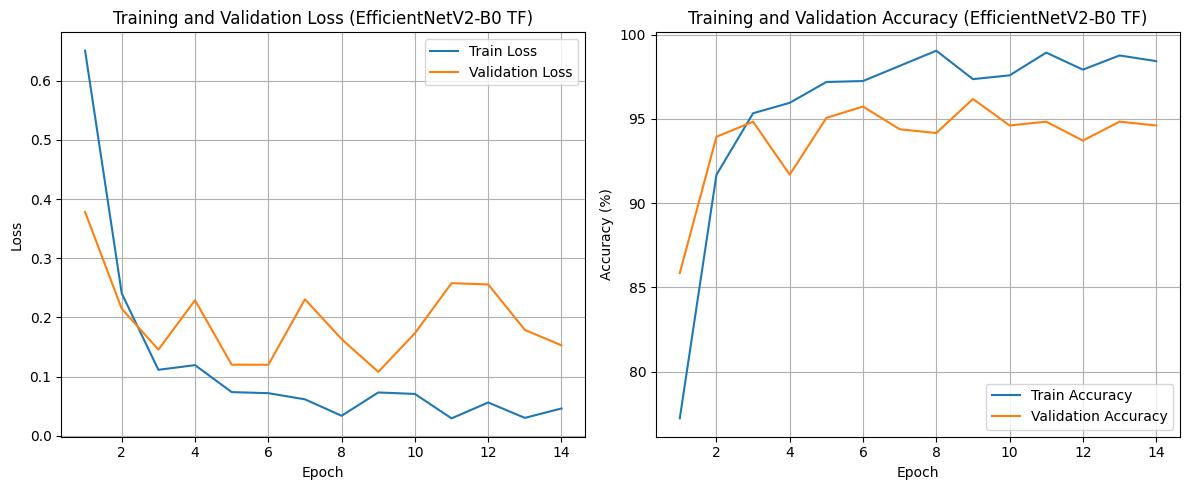


--- Final Evaluation on VALIDATION Set (using best weights) ---
Loading best model weights from: /kaggle/working/models_tf/best_classifier_effnetv2b0_tf.weights.h5
Weights loaded into evaluation model.

Validation Performance (using model.evaluate):
Validation Loss    : 0.1080
Validation Accuracy: 96.18%

Calculating detailed validation metrics (Precision, Recall, F1)...
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step

Validation Metrics (Best EfficientNetV2-B0 TF Model - calculated via sklearn):
Accuracy : 0.9618
Precision (for Kanama): 0.9720
Recall (for Kanama)   : 0.9498
F1 Score (for Kanama) : 0.9607
Validation confusion matrix saved to: /kaggle/working/models_tf/validation_confusion_matrix_effnetv2b0_tf.png


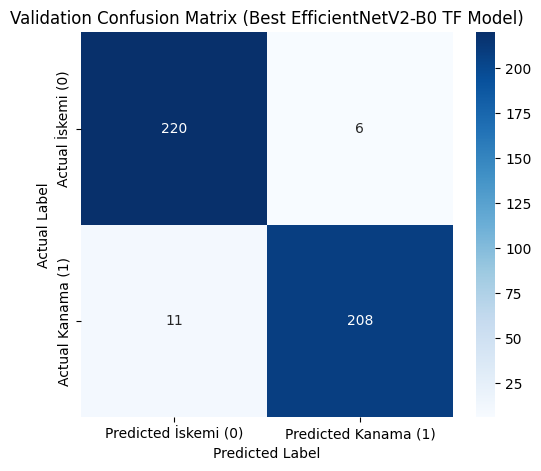


--- Generating Predictions on TEST Set ---
NOTE: Ground truth labels for the test set are unknown.
      Metrics cannot be calculated. Generating predictions only.
Running inference on test images...


InvalidArgumentError: Graph execution error:

Detected at node data_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-cb874bb92d9a>", line 413, in <cell line: 410>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 346, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>

Detected at node data_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-cb874bb92d9a>", line 413, in <cell line: 410>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 346, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>

Detected unsupported operations when trying to compile graph __inference_one_step_on_data_107606[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data_1}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=1){{node data_1}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-14-cb874bb92d9a>", line 413, in <cell line: 410>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_107606[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_108343]

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


print("--- Setup and Downloads ---")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
RANDOM_STATE = 42
MODEL_SAVE_DIR = "/kaggle/working/models_tf"
BEST_MODEL_NAME = 'best_classifier_effnetv2b0_tf.weights.h5'
PLOT_SAVE_NAME = 'training_metrics_effnetv2b0_tf.png'
CONFUSION_MATRIX_SAVE_NAME = 'validation_confusion_matrix_effnetv2b0_tf.png'
PREDICTIONS_CSV_NAME = 'test_predictions_effnetv2b0_tf.csv'
PATIENCE_EARLY_STOPPING = 5

try:
    dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset", silent=True)
    print(f"Dataset checked/downloaded via kagglehub to: {dataset_path}")
    base_data_dir = os.path.join(dataset_path, 'İNME VERİ SETİ')
except Exception as e:
    print(f"Warning: kagglehub dataset download failed: {e}")
    print("Attempting to use default Kaggle input path...")
    base_data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'

print(f"Using base data directory: {base_data_dir}")

if not os.path.isdir(base_data_dir):
     print(f"ERROR: Base data directory not found: {base_data_dir}")
     print("Please ensure the dataset is correctly attached or downloaded.")
     exit()

ischemic_path = os.path.join(base_data_dir, "İskemi/PNG")
hemorrhagic_path = os.path.join(base_data_dir, "Kanama/PNG")
test_png_path = os.path.join(base_data_dir, "YarısmaVeriSeti_2_Oturum/PNG")

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(f"Model and plots will be saved in: {MODEL_SAVE_DIR}")

best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
plot_save_path = os.path.join(MODEL_SAVE_DIR, PLOT_SAVE_NAME)
cm_save_path = os.path.join(MODEL_SAVE_DIR, CONFUSION_MATRIX_SAVE_NAME)
csv_save_path = os.path.join(MODEL_SAVE_DIR, PREDICTIONS_CSV_NAME)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs found.")
        print(f"Using GPU: {tf.test.gpu_device_name()}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected, using CPU.")

print("\n--- Data Preparation (Train/Validation) ---")

image_paths = []
labels = []

ischemic_files = glob.glob(os.path.join(ischemic_path, '*.png'))
if not ischemic_files: print(f"Warning: No files found in {ischemic_path}")
image_paths.extend(ischemic_files)
labels.extend([0] * len(ischemic_files))
print(f"Found {len(ischemic_files)} ischemic images.")

hemorrhagic_files = glob.glob(os.path.join(hemorrhagic_path, '*.png'))
if not hemorrhagic_files: print(f"Warning: No files found in {hemorrhagic_path}")
image_paths.extend(hemorrhagic_files)
labels.extend([1] * len(hemorrhagic_files))
print(f"Found {len(hemorrhagic_files)} hemorrhagic images.")

if not image_paths:
    print("ERROR: No training/validation images found. Exiting.")
    exit()
else:
    print(f"Total train/val images found: {len(image_paths)}")

train_files, val_files, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
)
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

print("\n--- Data Preparation (Test Set) ---")
test_files = glob.glob(os.path.join(test_png_path, '*.png'))
if not test_files:
    print(f"Warning: No files found in the test directory: {test_png_path}")
else:
    print(f"Found {len(test_files)} images in the test set directory ({test_png_path}).")
    test_files.sort()

print("\n--- Creating TensorFlow Datasets ---")

AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess_image(path, label):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = efficientnet_v2.preprocess_input(image)
        return image, tf.cast(label, tf.int32)
    except Exception as e:
        tf.print(f"Warning: Error processing image {path}: {e}. Skipping.")
        return None, None

def load_and_preprocess_test_image(path):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = efficientnet_v2.preprocess_input(image)
        return image, path
    except Exception as e:
        tf.print(f"Warning: Error processing test image {path}: {e}. Skipping.")
        return None, None

train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))

train_ds = (
    train_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .filter(lambda x, y: x is not None)
    .cache()
    .shuffle(buffer_size=len(train_files))
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .filter(lambda x, y: x is not None)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

print("Train and Validation Datasets created.")

if test_files:
    test_ds = tf.data.Dataset.from_tensor_slices(test_files)
    test_ds = (
        test_ds
        .map(load_and_preprocess_test_image, num_parallel_calls=AUTOTUNE)
        .filter(lambda x, y: x is not None)
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=AUTOTUNE)
    )
    print("Test Dataset created.")
else:
    test_ds = None

print("\n--- Model Setup (TensorFlow/Keras) ---")

def build_model(num_classes=2):
    base_model = efficientnet_v2.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = True

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation=None, name="predictions")(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_model(num_classes=2)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()
print("Model, Loss function, and Optimizer defined.")

print("\n--- Training (TensorFlow/Keras) ---")

model_checkpoint_callback = ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE_EARLY_STOPPING,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

best_val_accuracy = max(history.history['val_accuracy']) * 100
print("\nTraining complete!")
print(f"Best Validation Accuracy achieved: {best_val_accuracy:.2f}%")
if early_stopping_callback.stopped_epoch > 0:
    print(f"Training stopped early at epoch {early_stopping_callback.stopped_epoch + 1} due to no improvement.")
print(f"Best model weights saved to: {best_model_path}")

print("\n--- Plotting Training Metrics ---")

epochs_trained = len(history.history['loss'])
epochs_range = range(1, epochs_trained + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (EfficientNetV2-B0 TF)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in history.history['accuracy']], label='Train Accuracy')
plt.plot(epochs_range, [acc * 100 for acc in history.history['val_accuracy']], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (EfficientNetV2-B0 TF)')
plt.legend()
plt.grid(True)

plt.tight_layout()
try:
    plt.savefig(plot_save_path)
    print(f"Training metrics plot saved to: {plot_save_path}")
except Exception as e:
    print(f"Error saving plot: {e}")
plt.show()

print("\n--- Final Evaluation on VALIDATION Set (using best weights) ---")

if os.path.exists(best_model_path):
    print(f"Loading best model weights from: {best_model_path}")
    eval_model = build_model(num_classes=2)
    eval_model.load_weights(best_model_path)
    eval_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss=SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    print("Weights loaded into evaluation model.")

    print("\nValidation Performance (using model.evaluate):")
    loss, accuracy = eval_model.evaluate(val_ds, verbose=0)
    print(f"Validation Loss    : {loss:.4f}")
    print(f"Validation Accuracy: {accuracy*100:.2f}%")

    print("\nCalculating detailed validation metrics (Precision, Recall, F1)...")
    val_predictions_logits = eval_model.predict(val_ds)
    y_pred_val = np.argmax(val_predictions_logits, axis=-1)

    y_true_val = []
    for _, labels_batch in val_ds:
        y_true_val.extend(labels_batch.numpy())
    y_true_val = np.array(y_true_val)

    accuracy_sk = accuracy_score(y_true_val, y_pred_val)
    precision_sk = precision_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
    recall_sk = recall_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)
    f1_sk = f1_score(y_true_val, y_pred_val, labels=[0, 1], average='binary', pos_label=1, zero_division=0)

    print("\nValidation Metrics (Best EfficientNetV2-B0 TF Model - calculated via sklearn):")
    print(f"Accuracy : {accuracy_sk:.4f}")
    print(f"Precision (for Kanama): {precision_sk:.4f}")
    print(f"Recall (for Kanama)   : {recall_sk:.4f}")
    print(f"F1 Score (for Kanama) : {f1_sk:.4f}")

    cm = confusion_matrix(y_true_val, y_pred_val, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted İskemi (0)', 'Predicted Kanama (1)'],
                yticklabels=['Actual İskemi (0)', 'Actual Kanama (1)'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Validation Confusion Matrix (Best EfficientNetV2-B0 TF Model)')
    try:
        plt.savefig(cm_save_path)
        print(f"Validation confusion matrix saved to: {cm_save_path}")
    except Exception as e:
        print(f"Error saving confusion matrix plot: {e}")
    plt.show()

else:
     print(f"ERROR: Best model weights file not found at {best_model_path}. Cannot perform final validation evaluation.")

print("\n--- Generating Predictions on TEST Set ---")
print("NOTE: Ground truth labels for the test set are unknown.")
print("      Metrics cannot be calculated. Generating predictions only.")

if test_ds and 'eval_model' in locals() and os.path.exists(best_model_path):
    print("Running inference on test images...")
    test_predictions_logits = eval_model.predict(test_ds)
    test_predictions_classes = np.argmax(test_predictions_logits, axis=-1)

    test_image_paths = []
    for _, paths_batch in test_ds:
        test_image_paths.extend([p.numpy().decode('utf-8') for p in paths_batch])

    print(f"Generated {len(test_predictions_classes)} predictions for the test set.")
    print(f"Number of test image paths recovered: {len(test_image_paths)}")

    if len(test_predictions_classes) != len(test_image_paths):
        print("Warning: Mismatch between number of predictions and number of image paths!")
        if len(test_predictions_classes) == len(test_files):
             print("Using original test_files list for paths.")
             test_image_paths = test_files
        else:
             print("Cannot reliably match predictions to file names. Skipping CSV generation.")
             test_image_paths = None

    if test_image_paths:
        print("\nExample Test Predictions (Image Path -> Predicted Label [0=İskemi, 1=Kanama]):")
        for i in range(min(10, len(test_predictions_classes))):
             print(f"{os.path.basename(test_image_paths[i])} -> {test_predictions_classes[i]}")

        try:
            predictions_df = pd.DataFrame({'ImagePath': test_image_paths, 'Prediction': test_predictions_classes})
            predictions_df['ImageName'] = predictions_df['ImagePath'].apply(os.path.basename)
            predictions_df = predictions_df[['ImageName', 'Prediction']]
            base_name_map = {os.path.basename(f): f for f in test_files}
            predictions_df['sort_key'] = predictions_df['ImageName'].map(base_name_map)
            predictions_df.sort_values(by='sort_key', inplace=True)

            predictions_df[['ImageName', 'Prediction']].to_csv(csv_save_path, index=False)
            print(f"\nTest predictions saved to: {csv_save_path}")
        except Exception as e:
            print(f"\nError saving test predictions to CSV: {e}")

elif not test_files:
    print("Skipping test set prediction as no test files were found.")
else:
    print("Skipping test set prediction as best model weights file was not found or model could not be loaded.")

print("\n--- Script Finished ---")

--- Setup ---
PyTorch Version: 2.5.1+cu121
TensorFlow Version: 2.17.1
Keras Version: 3.5.0
Dataset checked/downloaded via kagglehub to: /kaggle/input/inme-veri-seti-stroke-dataset
Using base data directory: /kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ
PyTorch using device: cuda

--- Recreating Validation Set ---
Identified 445 validation samples (from PNG folders) based on RANDOM_STATE=42.

--- Processing Model: ResNet-18 (PyTorch) ---
Attempting to load resnet18 from /kaggle/working/models/best_classifier_imagenet.pth
Successfully loaded resnet18 model.


<ipython-input-17-b35f77955073>:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device_pt))


Found 434 correct and 11 incorrect predictions.


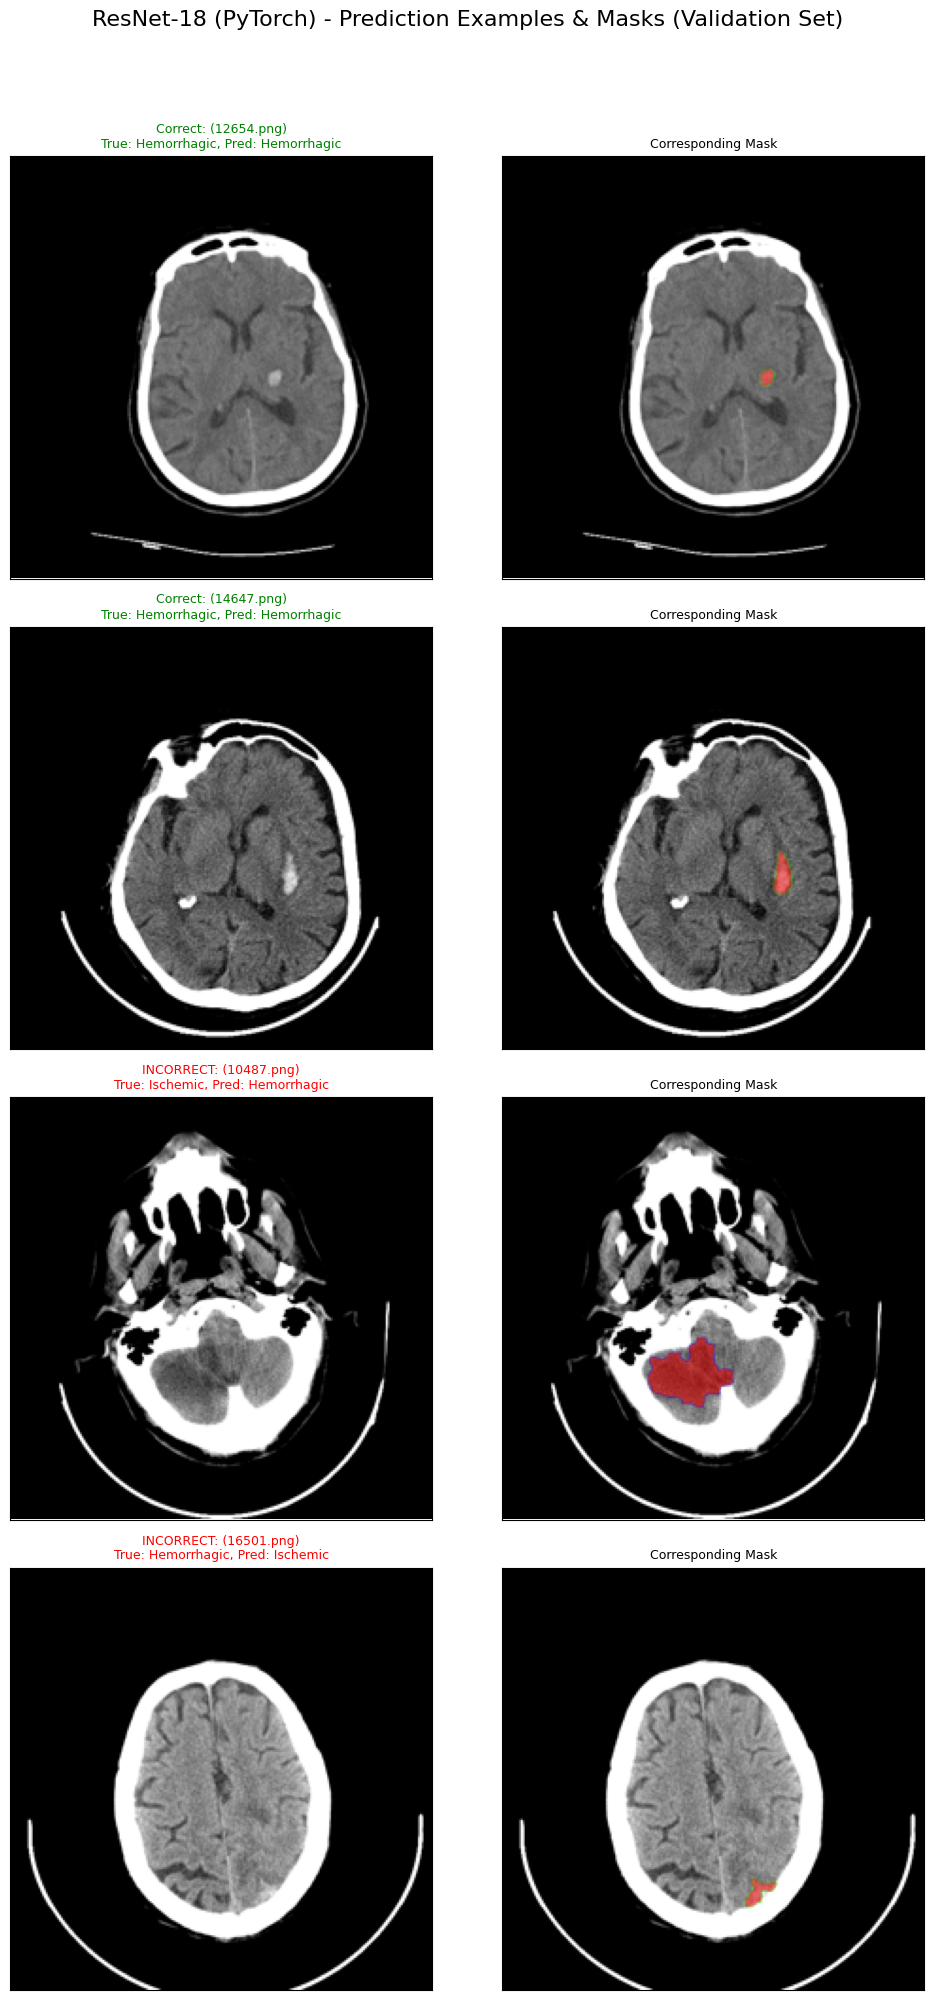


--- Processing Model: SimpleCNN (PyTorch) ---
Attempting to load cnn from /kaggle/working/models/best_classifier_cnn.pth
Successfully loaded cnn model.


<ipython-input-17-b35f77955073>:278: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device_pt))


Found 434 correct and 11 incorrect predictions.


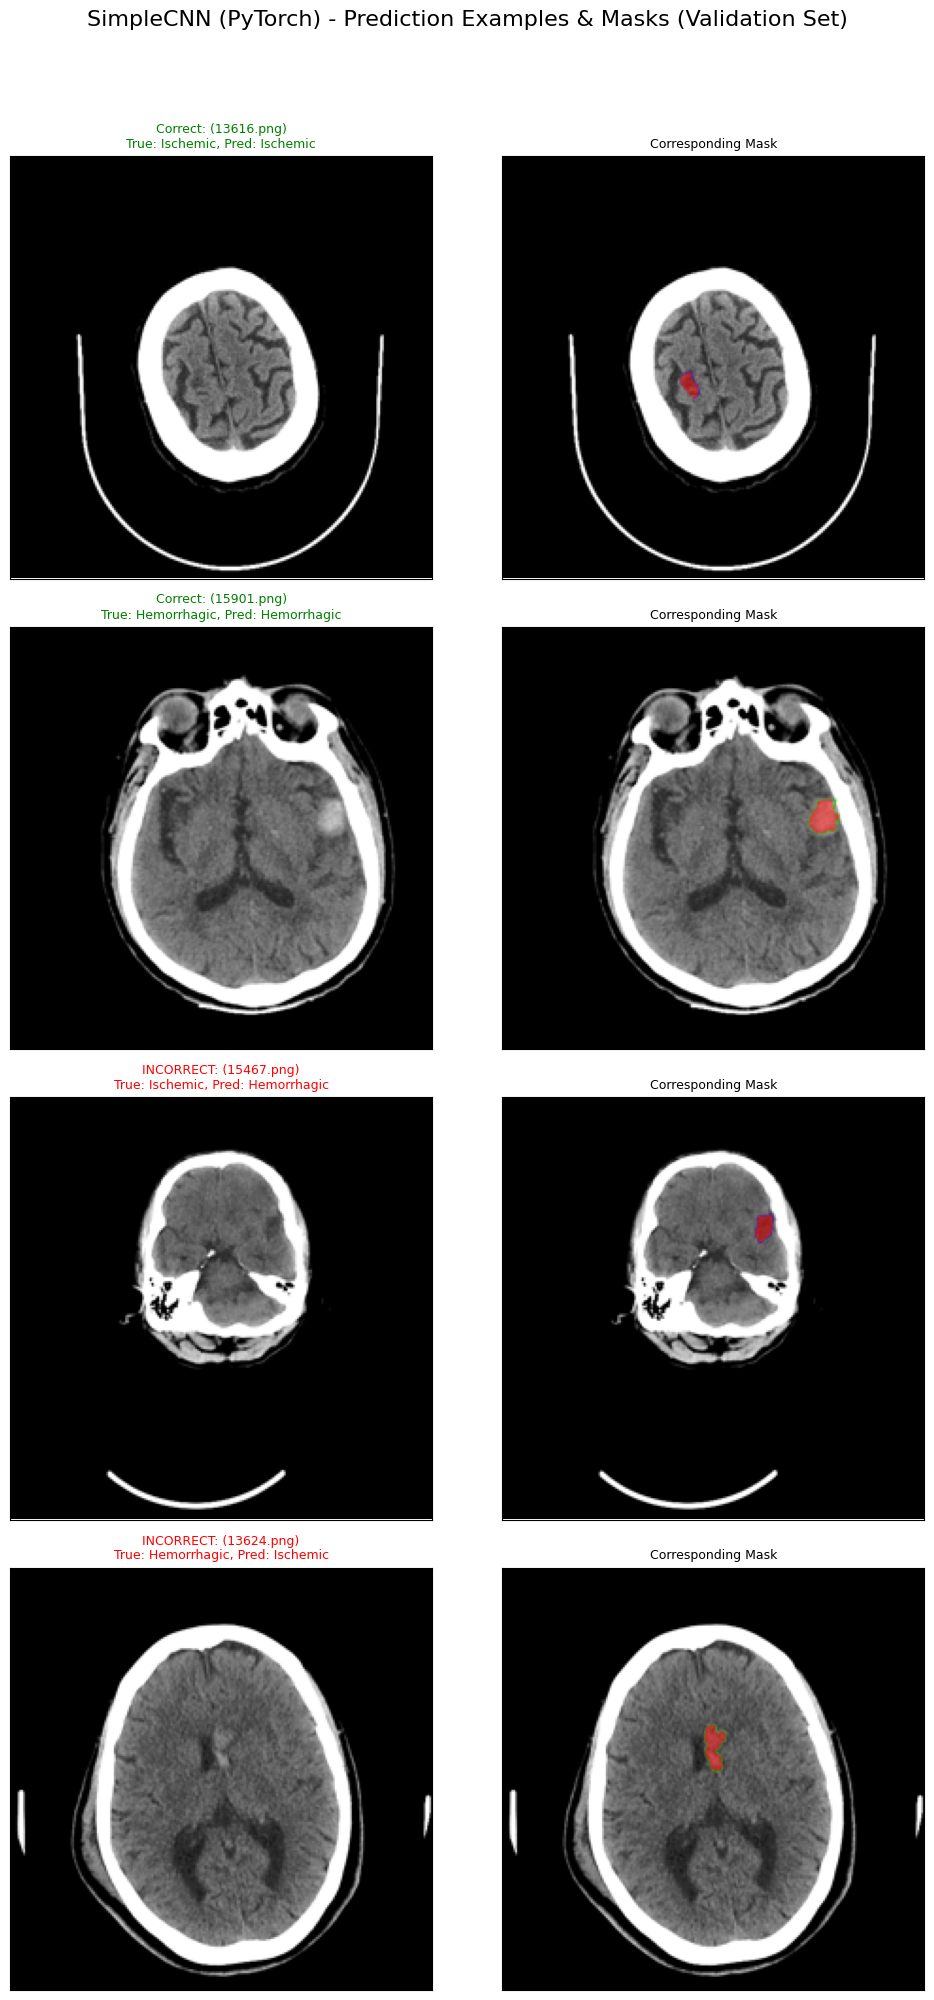


--- Processing Model: EfficientNetV2-B0 (TF/Keras) ---
Attempting to load effnetv2b0_tf from /kaggle/working/models_tf/best_classifier_effnetv2b0_tf.weights.h5
TensorFlow model structure built and weights loaded.
Successfully loaded effnetv2b0_tf model.
Found 428 correct and 17 incorrect predictions.


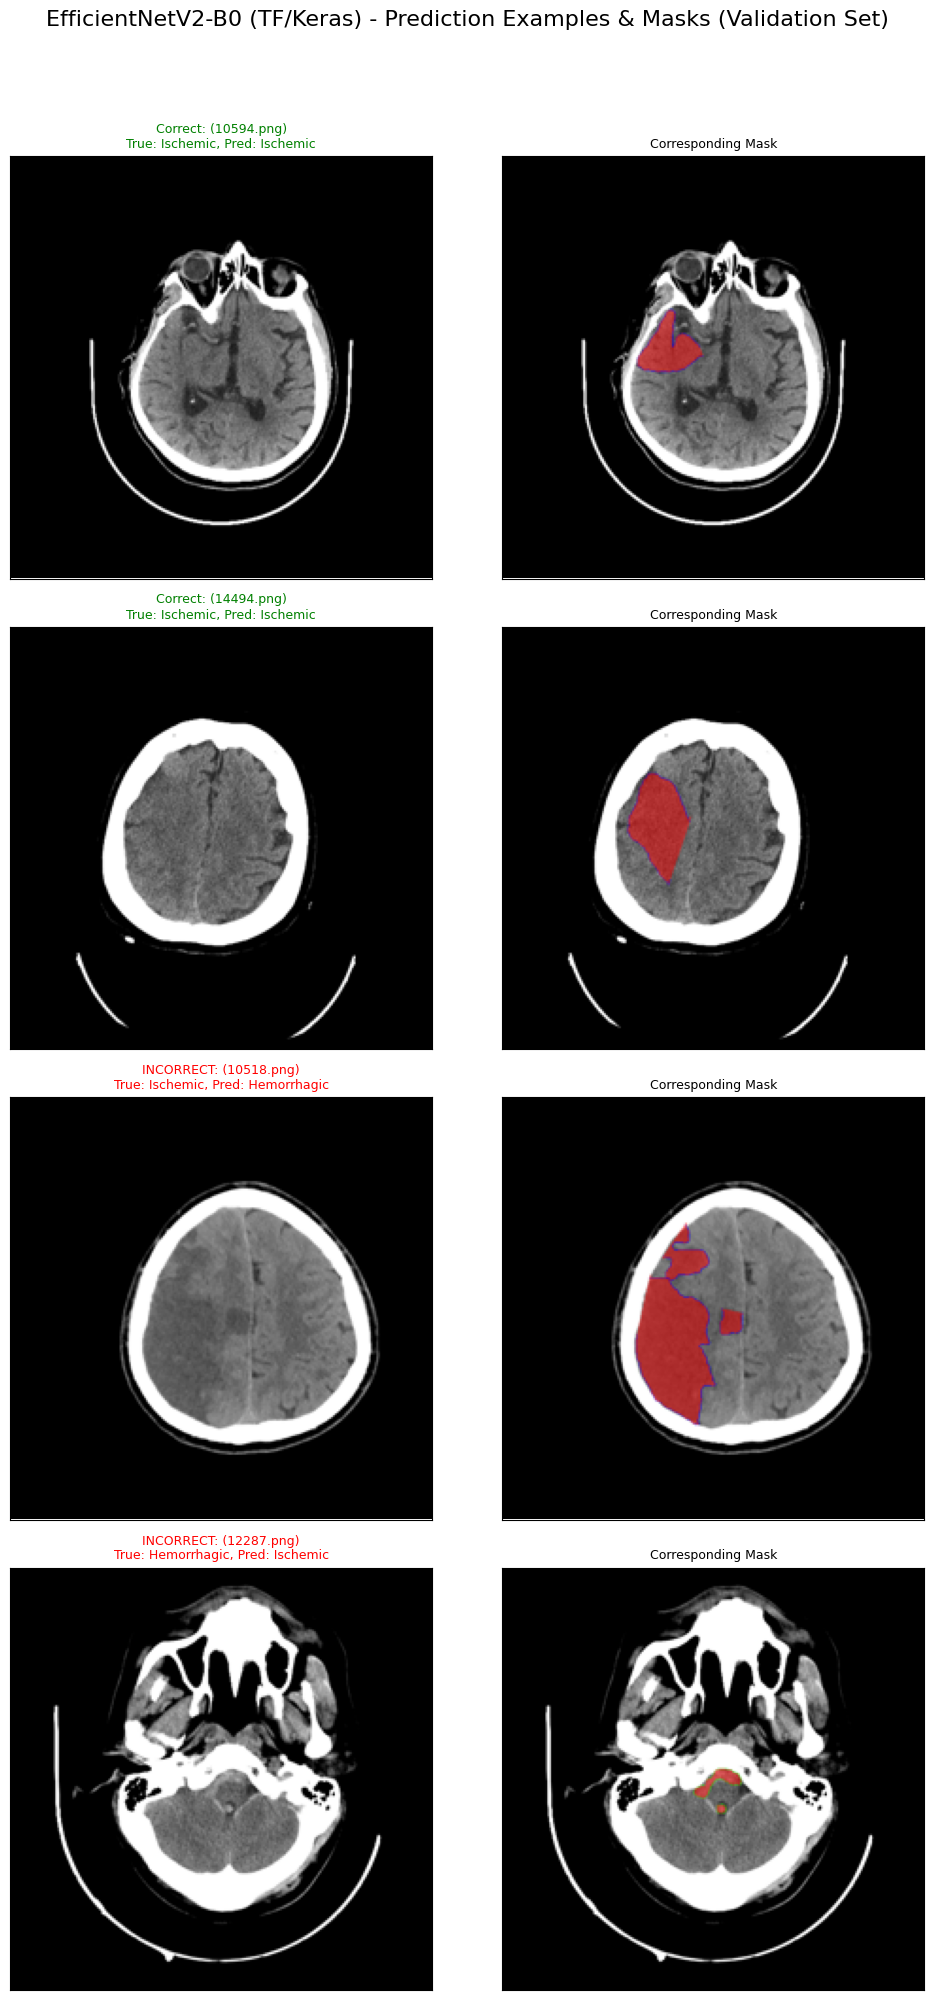


--- Visualization Finished ---


In [ ]:

print("--- Setup ---")
print(f"PyTorch Version: {torch.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")


# --- Configuration (Match your training scripts) ---
IMG_SIZE = 224
BATCH_SIZE = 32 # Used for prediction DataLoader/Batching
RANDOM_STATE = 42 # MUST match the state used for train/val split
# <<< CHANGE: Reduce number of samples per category >>>
NUM_SAMPLES_PER_CATEGORY = 2 # Number of correct/incorrect samples to show

# --- Model Save Directories (Adjust if needed) ---
PYTORCH_MODEL_SAVE_DIR = "/kaggle/working/models" # Dir for PyTorch models
TENSORFLOW_MODEL_SAVE_DIR = "/kaggle/working/models_tf" # Dir for TensorFlow models

# --- Model File Names ---
# PyTorch Models
RESNET_MODEL_NAME_PT = 'best_classifier_imagenet.pth' # Assuming this is ResNet-18
CNN_MODEL_NAME_PT = 'best_classifier_cnn.pth'
# TensorFlow Model
EFFNET_MODEL_NAME_TF = 'best_classifier_effnetv2b0_tf.weights.h5' # TensorFlow EffNet path

# --- Label Mapping ---
label_map = {0: "Ischemic", 1: "Hemorrhagic"}

# --- Dataset Handling (Repeat the path finding logic) ---
try:
    try:
        dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")
    except TypeError:
        print("Warning: kagglehub.dataset_download silent=True failed, trying without.")
        dataset_path = kagglehub.dataset_download("orvile/inme-veri-seti-stroke-dataset")

    print(f"Dataset checked/downloaded via kagglehub to: {dataset_path}")
    base_data_dir = os.path.join(dataset_path, 'İNME VERİ SETİ')
except Exception as e:
    print(f"Warning: kagglehub dataset download failed: {e}")
    print("Attempting to use default Kaggle input path...")
    base_data_dir = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ' # Standard Kaggle path

print(f"Using base data directory: {base_data_dir}")

if not os.path.isdir(base_data_dir):
     print(f"ERROR: Base data directory not found: {base_data_dir}")
     exit()

# <<< Paths to the PNG image folders (as used in training/validation split) >>>
ischemic_png_path = os.path.join(base_data_dir, "İskemi/PNG")
hemorrhagic_png_path = os.path.join(base_data_dir, "Kanama/PNG")
# <<< Paths to the OVERLAY mask folders >>>
ischemic_OVERLAY_path = os.path.join(base_data_dir, "İskemi/OVERLAY")
hemorrhagic_OVERLAY_path = os.path.join(base_data_dir, "Kanama/OVERLAY")


# --- Device Check (Primarily for PyTorch models) ---
device_pt = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch using device: {device_pt}")

# --- Recreate Validation Set EXACTLY ---
print("\n--- Recreating Validation Set ---")
all_image_paths = []
all_labels = []

# Use the PNG paths for creating the validation split, as done previously
ischemic_files = glob.glob(os.path.join(ischemic_png_path, '*.png'))
if not ischemic_files: print(f"Warning: No PNG files found in {ischemic_png_path}")
all_image_paths.extend(ischemic_files)
all_labels.extend([0] * len(ischemic_files))

hemorrhagic_files = glob.glob(os.path.join(hemorrhagic_png_path, '*.png'))
if not hemorrhagic_files: print(f"Warning: No PNG files found in {hemorrhagic_png_path}")
all_image_paths.extend(hemorrhagic_files)
all_labels.extend([1] * len(hemorrhagic_files))

if not all_image_paths:
    print("ERROR: No training/validation PNG images found. Exiting.")
    exit()

# Use the SAME random_state and test_size to get the identical validation set
_, val_files, _, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=RANDOM_STATE, stratify=all_labels
)
print(f"Identified {len(val_files)} validation samples (from PNG folders) based on RANDOM_STATE={RANDOM_STATE}.")

# --- Custom Dataset (Modified for Both PyTorch and TensorFlow/Keras) ---
# No change needed here, still loads the primary image from val_files
class PredictionDatasetMulti(Dataset):
    def __init__(self, image_paths, labels, img_size):
        self.image_paths = image_paths
        self.labels = labels
        self.img_size = img_size
        self.transform_pt = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.transform_keras_base = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            img_pil = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Warning: Error loading image {image_path}: {e}. Returning dummy data.")
            dummy_pt = torch.zeros((3, self.img_size, self.img_size), dtype=torch.float32)
            dummy_keras = torch.zeros((3, self.img_size, self.img_size), dtype=torch.float32)
            return dummy_pt, dummy_keras, torch.tensor(-1, dtype=torch.long), image_path

        img_transformed_pt = self.transform_pt(img_pil)
        img_tensor_keras_ready = self.transform_keras_base(img_pil)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return img_transformed_pt, img_tensor_keras_ready, label_tensor, image_path


# --- Create Validation DataLoader (NO SHUFFLE) ---
val_pred_dataset = PredictionDatasetMulti(val_files, val_labels, img_size=IMG_SIZE)
val_pred_loader = DataLoader(val_pred_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# --- Define Model Architectures (PyTorch SimpleCNN) ---
# No changes needed here
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # ... (Conv, ReLU, Pool layers as before) ...
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self._calculate_flattened_size(IMG_SIZE)
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def _calculate_flattened_size(self, img_size):
        x = torch.zeros(1, 3, img_size, img_size) # Dummy input
        temp_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        temp_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        temp_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        temp_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        temp_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        temp_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        x = temp_pool1(torch.relu(temp_conv1(x)))
        x = temp_pool2(torch.relu(temp_conv2(x)))
        x = temp_pool3(torch.relu(temp_conv3(x)))
        self.flattened_size = x.numel() // x.shape[0]

    def forward(self, x):
        # ... (forward pass as before) ...
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.flattened_size)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- Define Model Architecture (TensorFlow/Keras EfficientNetV2-B0 - matching training) ---
# No changes needed here
def build_tf_effnetv2b0_model(num_classes=2, img_size=IMG_SIZE):
    # ... (model definition as before) ...
    base_model = efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights=None, input_shape=(img_size, img_size, 3)
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation=None, name="predictions")(x)
    model = keras.Model(inputs, outputs)
    return model

# --- Helper Function to Get Predictions (Handles Both Frameworks) ---
# No changes needed here
def get_predictions(model, model_type, dataloader, device_pt):
    # ... (prediction logic as before) ...
    all_preds = []
    all_true_labels = []
    all_image_paths = []

    if model_type in ['resnet18', 'cnn']: # PyTorch models
        model.eval()
        with torch.no_grad():
            for inputs_pt, _, labels, paths in dataloader:
                valid_indices = [i for i, lbl in enumerate(labels.tolist()) if lbl != -1]
                if not valid_indices: continue
                inputs_pt = inputs_pt[valid_indices].to(device_pt)
                labels = labels[valid_indices].to(device_pt)
                valid_paths = [paths[i] for i in valid_indices]
                outputs = model(inputs_pt)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_image_paths.extend(valid_paths)

    elif model_type == 'effnetv2b0_tf': # TensorFlow/Keras model
        for _, inputs_keras_ready_pt, labels, paths in dataloader:
            valid_indices = [i for i, lbl in enumerate(labels.tolist()) if lbl != -1]
            if not valid_indices: continue
            inputs_keras_ready_pt = inputs_keras_ready_pt[valid_indices]
            labels = labels[valid_indices]
            valid_paths = [paths[i] for i in valid_indices]
            inputs_np = inputs_keras_ready_pt.cpu().numpy()
            inputs_np = np.transpose(inputs_np, (0, 2, 3, 1))
            inputs_np_scaled = inputs_np * 255.0
            inputs_tf_preprocessed = efficientnet_v2.preprocess_input(inputs_np_scaled)
            preds_logits = model.predict(inputs_tf_preprocessed, verbose=0)
            preds = np.argmax(preds_logits, axis=-1)
            all_preds.extend(preds)
            all_true_labels.extend(labels.numpy())
            all_image_paths.extend(valid_paths)
    else:
        print(f"Warning: Unknown model type '{model_type}' in get_predictions.")

    return np.array(all_true_labels), np.array(all_preds), all_image_paths

# --- Helper Function to Load Models (Handles Both Frameworks) ---
# No changes needed here
def load_model(model_type, model_path, num_classes=2, device_pt='cpu', img_size=IMG_SIZE):
    # ... (model loading logic as before) ...
    print(f"Attempting to load {model_type} from {model_path}")
    if not os.path.exists(model_path):
        print(f"ERROR: Model file not found: {model_path}")
        return None

    model = None
    try:
        if model_type == 'resnet18':
            model = models_pt.resnet18(weights=None)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
            model.load_state_dict(torch.load(model_path, map_location=device_pt))
            model.to(device_pt)
            model.eval()
        elif model_type == 'cnn':
            model = SimpleCNN(num_classes=num_classes)
            model._calculate_flattened_size(img_size)
            model.fc1 = nn.Linear(model.flattened_size, 512)
            model.fc2 = nn.Linear(512, num_classes)
            model.load_state_dict(torch.load(model_path, map_location=device_pt))
            model.to(device_pt)
            model.eval()
        elif model_type == 'effnetv2b0_tf':
            model = build_tf_effnetv2b0_model(num_classes=num_classes, img_size=img_size)
            model.load_weights(model_path)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
            print("TensorFlow model structure built and weights loaded.")
        else:
            print(f"ERROR: Unknown model type '{model_type}'")
            return None

        print(f"Successfully loaded {model_type} model.")
        return model

    except Exception as e:
        print(f"ERROR loading model {model_type} from {model_path}: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- Helper Function to get Mask Path ---
def get_mask_path(image_path):
    """Constructs the path to the corresponding mask in the OVERLAY folder."""
    try:
        img_filename = os.path.basename(image_path)
        img_dir = os.path.dirname(image_path) # e.g., ..../İskemi/PNG
        class_dir = os.path.dirname(img_dir)   # e.g., ..../İskemi
        OVERLAY_dir = os.path.join(class_dir, "OVERLAY")
        mask_path = os.path.join(OVERLAY_dir, img_filename)
        # Optional: Check if the constructed mask path actually exists
        if os.path.exists(mask_path):
             return mask_path
        else:
             # print(f"Warning: Mask file not found at expected path: {mask_path}")
             return None
    except Exception as e:
        print(f"Error constructing mask path for {image_path}: {e}")
        return None

# --- Helper function to create a placeholder image ---
def create_placeholder(size, text="Not Found"):
    img = Image.new('RGB', size, color=(200, 200, 200))
    # Simple text drawing (requires PIL draw, but might not be installed/needed)
    # from PIL import ImageDraw
    # draw = ImageDraw.Draw(img)
    # draw.text((10, 10), text, fill=(0,0,0)) # Basic text
    # Alternative: Just return the grey image
    return img

# --- Main Plotting Loop ---
model_configs = [
    {'name': 'ResNet-18 (PyTorch)', 'type': 'resnet18',
     'path': os.path.join(PYTORCH_MODEL_SAVE_DIR, RESNET_MODEL_NAME_PT)},
    {'name': 'SimpleCNN (PyTorch)', 'type': 'cnn',
     'path': os.path.join(PYTORCH_MODEL_SAVE_DIR, CNN_MODEL_NAME_PT)},
    {'name': 'EfficientNetV2-B0 (TF/Keras)', 'type': 'effnetv2b0_tf',
     'path': os.path.join(TENSORFLOW_MODEL_SAVE_DIR, EFFNET_MODEL_NAME_TF)},
]

random.seed(RANDOM_STATE)

for config in model_configs:
    model_name = config['name']
    model_type = config['type']
    model_path = config['path']

    print(f"\n--- Processing Model: {model_name} ---")

    model = load_model(model_type, model_path, num_classes=2, device_pt=device_pt, img_size=IMG_SIZE)
    if model is None:
        print(f"Skipping visualization for {model_name} due to loading error.")
        continue

    true_labels, pred_labels, image_paths = get_predictions(model, model_type, val_pred_loader, device_pt)

    if len(true_labels) == 0:
        print("No valid predictions obtained. Skipping visualization.")
        continue

    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    print(f"Found {len(correct_indices)} correct and {len(incorrect_indices)} incorrect predictions.")

    # Select samples (NUM_SAMPLES_PER_CATEGORY is now 2)
    n_correct = min(NUM_SAMPLES_PER_CATEGORY, len(correct_indices))
    n_incorrect = min(NUM_SAMPLES_PER_CATEGORY, len(incorrect_indices))

    if n_correct < NUM_SAMPLES_PER_CATEGORY or n_incorrect < NUM_SAMPLES_PER_CATEGORY:
         print(f"Warning: Could only find {n_correct} correct and/or {n_incorrect} incorrect samples (requested {NUM_SAMPLES_PER_CATEGORY}).")

    if n_correct == 0 and n_incorrect == 0:
        print("No correct or incorrect samples to display.")
        continue

    selected_correct_indices = random.sample(list(correct_indices), n_correct) if n_correct > 0 else []
    selected_incorrect_indices = random.sample(list(incorrect_indices), n_incorrect) if n_incorrect > 0 else []
    selected_indices = selected_correct_indices + selected_incorrect_indices

    num_total_samples = len(selected_indices)
    if num_total_samples == 0: continue

    # <<< CHANGE: Plotting layout updated for image + mask pairs >>>
    # We need 2 columns (image, mask) and num_total_samples rows
    ncols = 2
    nrows = num_total_samples
    plt.figure(figsize=(5 * ncols, 5 * nrows + 1)) # Adjust figure size
    plt.suptitle(f"{model_name} - Prediction Examples & Masks (Validation Set)", fontsize=16)

    plot_index = 1 # Keep track of subplot position
    for i, idx in enumerate(selected_indices):
        img_path = image_paths[idx]
        true_label = true_labels[idx]
        pred_label = pred_labels[idx]

        # --- Load Original Image ---
        try:
            img = Image.open(img_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE)) # Resize for consistency
        except Exception as e:
            print(f"Error loading image {img_path} for plotting: {e}")
            img = create_placeholder((IMG_SIZE, IMG_SIZE), "Image Error")

        # --- Load Corresponding Mask ---
        mask_path = get_mask_path(img_path)
        mask_img = None
        if mask_path:
            try:
                mask_img = Image.open(mask_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE)) # Resize for consistency
            except Exception as e:
                print(f"Error loading mask {mask_path} for plotting: {e}")
                mask_img = create_placeholder((IMG_SIZE, IMG_SIZE), "Mask Error")
        else:
            # print(f"Mask not found for {img_path}") # Optional warning
            mask_img = create_placeholder((IMG_SIZE, IMG_SIZE), "Mask N/A")

        # --- Plot Image ---
        plt.subplot(nrows, ncols, plot_index)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

        true_text = label_map.get(true_label, f"Unknown ({true_label})")
        pred_text = label_map.get(pred_label, f"Unknown ({pred_label})")
        is_correct = (true_label == pred_label)
        result_prefix = "Correct:" if is_correct else "INCORRECT:"
        title_color = 'green' if is_correct else 'red'
        # Add filename to title for easier identification
        img_basename = os.path.basename(img_path)
        plt.title(f"{result_prefix} ({img_basename})\nTrue: {true_text}, Pred: {pred_text}", color=title_color, fontsize=9)
        plot_index += 1

        # --- Plot Mask ---
        plt.subplot(nrows, ncols, plot_index)
        plt.imshow(mask_img)
        plt.xticks([])
        plt.yticks([])
        plt.title("Corresponding Mask", fontsize=9)
        plot_index += 1
        # <<< CHANGE END >>>

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

print("\n--- Visualization Finished ---")